In [1]:
import pathlib
import os
import json
import Bio
from Bio.Seq import Seq
from Bio import pairwise2
from Bio.pairwise2 import format_alignment
import nglview as nv
from IPython.display import display, Math, Latex
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib as mpl
import matplotlib.lines as mlines
from pylab import savefig
import scipy
from scipy.optimize import curve_fit
from scipy.optimize import leastsq
from jupyterthemes import jtplot
#import pytraj as pt

# Retrieving all sequences downloaded from NCBI Genebank
with open(os.path.join(os.path.dirname(os.path.realpath('__file__')), "data", "allseq.json")) as f:
  allseq = json.load(f)

# Load SARS coronavirus Urbani, complete genome sequence (GenBank ID: AY278741.1)
with open(os.path.join(os.path.dirname(os.path.realpath('__file__')), "data", "sars_v1.json")) as f:
  Sars_v1 = json.load(f)

# Select one of the sequences from https://www.ncbi.nlm.nih.gov/genbank/sars-cov-2-seqs/
# I will start with the first one to be sequenced (potentially ground zero?)
cc = allseq['MN908947']

# Taking care of this weird(?) NCBI convention
# We know that this is a single-stranded RNA virus after all, right?
for s in "T":
    cc = cc.replace(s,"U")
cc = Seq(cc)

for s in "T":
    Sars_v1 = Sars_v1.replace(s,"U")
Sars_v1 = Seq(Sars_v1)

_ColormakerRegistry()

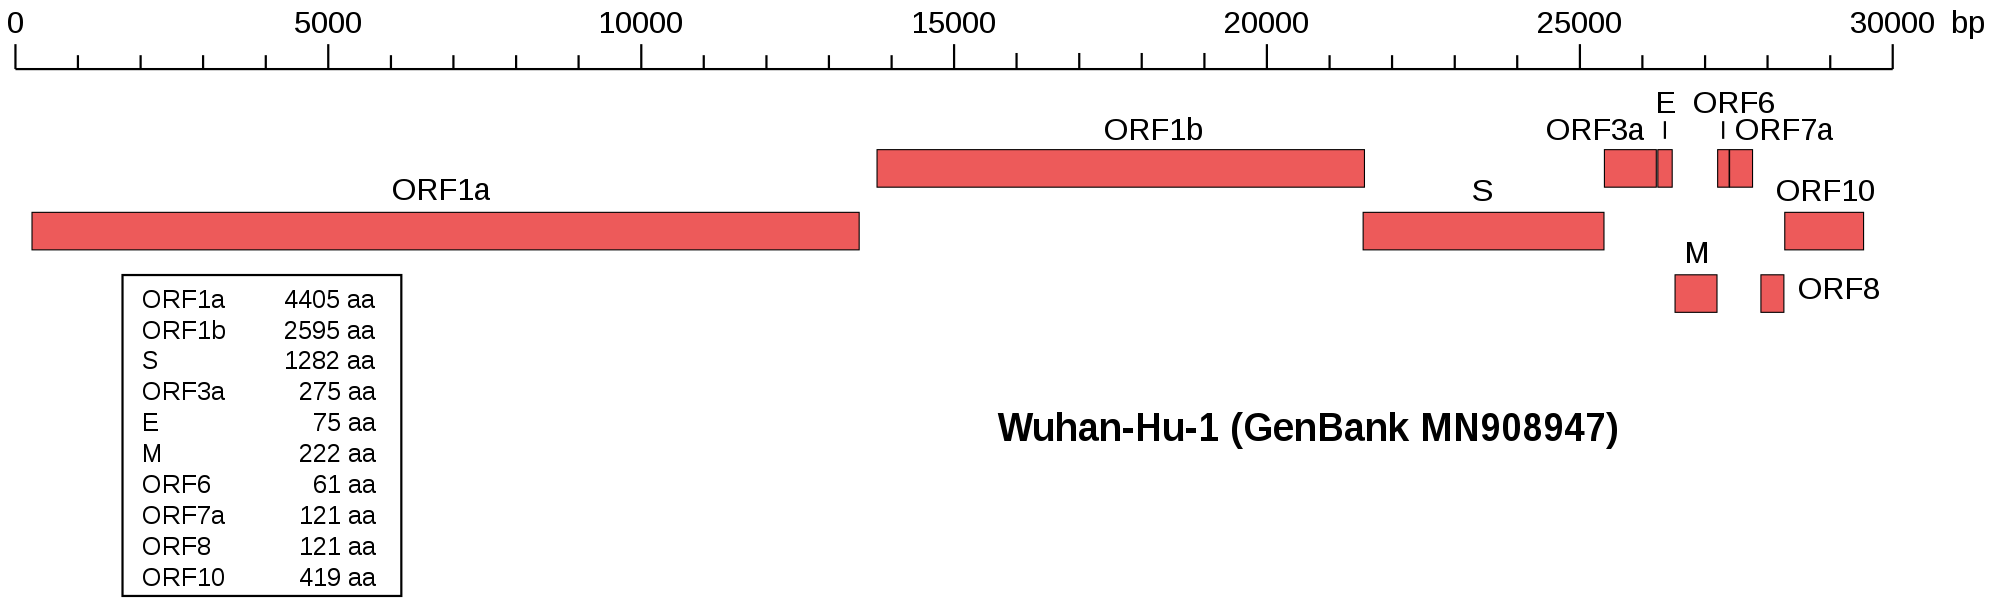

In [2]:
# Sars-cov-2 reference map
from IPython.display import Image
Image("./figures/2000px-SARS-CoV-2_genome.png")


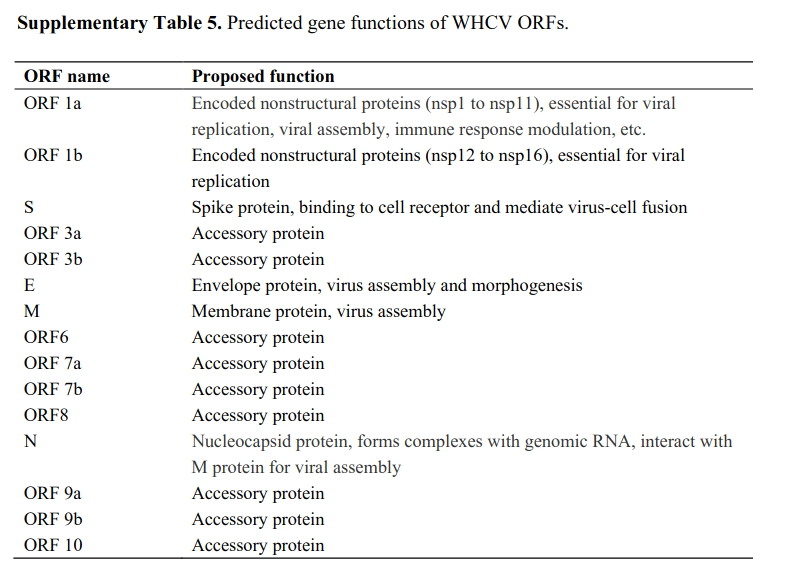

In [3]:
# From the 1st paper to describe Sars-Cov-2
# https://www.nature.com/articles/s41586-020-2008-3
Image("./figures/Wuetal_Nature_2020_SuppTable5.png")

In [5]:
# SARS-CoV-2 breakdown (parsing) and translation
###

# notes on Structure models of all mature peptides in 2019-nCoV genome by C-I-TASSER
# from https://zhanglab.ccmb.med.umich.edu/C-I-TASSER/2019-nCov/
#
#
#
Sars2 = {}
# initial portion, non-conding? garbage? silent?
vstart= cc[0:265]
vstart_tr = vstart.translate(table=1)
Sars2['Silent'] = vstart_tr.strip("*")

# Orf1ab polyprotein (not sure what that does - copy mechanism)
ORF1ab = cc[266-1:21555]
ORF1ab_tr = ORF1ab.translate(table=1)
Sars2['ORF1ab'] = ORF1ab_tr.strip("*")

ORF1a = cc[266-1:13483]
ORF1a_tr = ORF1a.translate(table=1)
Sars2['ORF1a'] = ORF1a_tr.strip("*")

# offset according to table above 3 x aa
ORF1b = cc[13468-1:21555]
ORF1b_tr = ORF1b.translate(table=1)
Sars2['ORF1b'] = ORF1b_tr.strip("*")

# Structural protein, surface glycoprotein
Spike = cc[21563-1:25384]
Spike_tr = Spike.translate()
Sars2['Spike'] = Spike_tr.strip("*")
#print(StructuralP_tr)


# ORF3a protein
# ORF3a (Zhang lab):
# Forms homotetrameric potassium sensitive ion channels (viroporin) and may modulate virus release. 
# Up-regulates expression of fibrinogen subunits FGA, FGB and FGG in host lung epithelial cells. 
# Induces apoptosis in cell culture. Downregulates the type 1 interferon receptor by inducing serine phosphorylation within the IFN alpha-receptor subunit 1 
# (IFNAR1) degradation motif and increasing IFNAR1 ubiquitination
ORF3a = cc[25393-1:26220]
ORF3a_tr = ORF3a.translate(table=1)
Sars2['ORF3a'] = ORF3a_tr.strip("*")
#print(ORF3a_tr)

# structural protein; E protein
EProt = cc[26245-1:26472]
EProt_tr = EProt.translate(table=1)
Sars2['EProt'] = EProt_tr.strip("*")
#print(len(Sars2['EProt']))

# structural protein; membrane glycoprotein
StructuralP_Glyc = cc[26523-1:27191]
StructuralP_Glyc_tr = StructuralP_Glyc.translate(table=1)
Sars2['StructuralP_Glyc'] = StructuralP_Glyc.strip("*")
#print(StructuralP_Glyc_tr)

# ORF6 protein
ORF6 = cc[27202-1:27387]
ORF6_tr = ORF6.translate(table=1)
Sars2['ORF6'] = ORF6_tr.strip("*")

# ORF7a protein
ORF7a = cc[27394-1:27759]
ORF7a_tr = ORF7a.translate(table=1)
Sars2['ORF7a'] = ORF7a_tr.strip("*")

# ORF8 protein
ORF8 = cc[27894-1:28259]
ORF8_tr = ORF8.translate(table=1)
Sars2['ORF8'] = ORF8_tr.strip("*")

# structural protein; nucleocapsid phosphoprotein
StructuralP_NP = cc[28274-1:29533]
StructuralP_NP_tr = StructuralP_NP.translate(table=1)
Sars2['StructuralP_NP'] = StructuralP_NP_tr.strip("*")

# ORF10 protein
ORF10 = cc[29558-1:29674]
ORF10_tr = ORF10.translate(table=1)
Sars2['ORF10'] = ORF10_tr.strip("*")

#print('Sars-Cov-2')
#[(i,len(j)) for i, j in Sars2.items()]

In [6]:
# Sars v1 (AY278741.1 (Sars 1 - SARS coronavirus Urbani, complete genome) breakdown (parsing) and translation)
###

Sars1 = {}

Sars1_ORF1ab = Sars_v1[265-1:21485]
Sars1_ORF1ab_tr = Sars1_ORF1ab.translate(table=1)
Sars1['ORF1ab'] = Sars1_ORF1ab_tr.strip("*")

Sars1_ORF1a = Sars_v1[265-1:13413]
Sars1_ORF1a_tr = Sars1_ORF1a.translate(table=1)
Sars1['ORF1a'] = Sars1_ORF1a_tr.strip("*")

Sars1_ORF1b = Sars_v1[13398-1:21485]
Sars1_ORF1b_tr = Sars1_ORF1b.translate(table=1)
Sars1['ORF1b'] = Sars1_ORF1b_tr.strip("*")


# surface spike glycoprotein
Sars1_Spike = Sars_v1[21492-1:25259]
Sars1_Spike_tr = Sars1_Spike.translate(table=1)
Sars1['Spike']  = Sars1_Spike_tr.strip("*")

# potential product, c-terminal similarity to porin
Sars1_ProteinX1 = Sars_v1[25268-1:26092]
Sars1_ProteinX1_tr = Sars1_ProteinX1.translate(table=1)
Sars1['X1'] = Sars1_ProteinX1_tr.strip("*")

Sars1_ProteinX2 = Sars_v1[25689-1:26153]
Sars1_ProteinX2_tr = Sars1_ProteinX2.translate(table=1)
Sars1['X2'] = Sars1_ProteinX2_tr.strip("*")

# Envelope protein
Sars1_ProteinE = Sars_v1[26117-1:26347]
Sars1_ProteinE_tr = Sars1_ProteinE.translate(table=1)
Sars1['ProtE'] = Sars1_ProteinE_tr.strip("*")

# small membrane protein
Sars1_ProteinM = Sars_v1[26398-1:27063]
Sars1_ProteinM_tr = Sars1_ProteinM.translate(table=1)
Sars1['ProtM'] = Sars1_ProteinM_tr.strip("*")

# 
Sars1_ProteinX3 = Sars_v1[27074-1:27265]
Sars1_ProteinX3_tr = Sars1_ProteinX3.translate(table=1)
Sars1['X3'] = Sars1_ProteinX3_tr.strip("*")

#
Sars1_ProteinX4 = Sars_v1[27273-1:27641]
Sars1_ProteinX4_tr = Sars1_ProteinX4.translate(table=1)
Sars1['X4'] = Sars1_ProteinX4_tr.strip("*")

#
Sars1_ProteinX5 = Sars_v1[27864-1:28118]
Sars1_ProteinX5_tr = Sars1_ProteinX5.translate(table=1)
Sars1['X5'] = Sars1_ProteinX5_tr.strip("*")

# Nucleocapsid protein
Sars1_Protein_N = Sars_v1[28120-1:29388]
Sars1_Protein_N_tr = Sars1_Protein_N.translate(table=1)
Sars1['N'] = Sars1_Protein_N_tr.strip("*")

Sars_v1_tr = Sars_v1.translate(table=1)
#print('SARS coronavirus Urbani')
#[(i,len(j)) for i, j in Sars1.items()]

In [7]:
#Sars_v1_tr.find(Sars2['Spike'][100:102])


In [7]:
# Pairwise sequence alignment
# https://biopython.org/DIST/docs/api/Bio.pairwise2-module.html
# Scores seem a bit too high, not sure if this makes sense.
alignment = pairwise2.align.globalxx(Sars2['Spike'],Sars1['Spike'])
#for a in alignment:
#    print(format_alignment(*a))
    

## SARS-CoV-2 spike glycoprotein (closed state) 
from https://www.cell.com/cell/fulltext/S0092-8674(20)30262-2?_returnURL=https%3A%2F%2Flinkinghub.elsevier.com%2Fretrieve%2Fpii%2FS0092867420302622%3Fshowall%3Dtrue

In [8]:
view = nv.show_pdbid("6VXX")  # load Structure of the SARS-CoV-2 spike glycoprotein (closed state) from RCSB PDB and display viewer widget
view

NGLWidget()

## NMR structure of the SARS1 Coronavirus E protein pentameric ion channel
from https://www.sciencedirect.com/science/article/pii/S0005273618300580?via%3Dihub

In [9]:
view = nv.show_pdbid("5X29")  # NMR structure of the SARS Coronavirus E protein pentameric ion channel
view

NGLWidget()

In [11]:
## Protein 3a from deepmind's alpha fold ( https://deepmind.com/research/open-source/computational-predictions-of-protein-structures-associated-with-COVID-19 )
view_deep = nv.show_file('./data/structures_v2_8_4_2020_deep_mind/Protein_3a.pdb')
view_deep

NGLWidget()

# Channel ephys

The structure of ORF3a is not at RCSB PDB yet. But the following is a basic IV of the channel 
heterologously expressed in Xenopus oocytes.
<br /> At this point in time all we seem to have is a bit of ephys on SARSv1 ORF3a, nothing clear on protein E and no ephys whatsoever for SARS-CoV-2
<br /> From: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1567914/

![N‐terminal deletions affect voltage dependence and activation kinetics of rat eag channels](./figures/Lu_et_al_2006_Fig4.png)
The 3a protein forms an ion channel in Xenopus oocytes. 

How similar is the above kinetics to a typical noninactivating potassium channel (e.g. Kv10.1)?
https://channelpedia.epfl.ch/ionchannels/33#a1723

![N‐terminal deletions affect voltage dependence and activation kinetics of rat eag channels](./figures/Terlau_et_al_2004_Fig1.png)
from https://physoc.onlinelibrary.wiley.com/doi/full/10.1111/j.1469-7793.1997.537bj.x?sid=nlm%3Apubmed
Where voltage dependence of activation can be estimated by fitting the IV relationships following Hodgkin‐Huxley formalism:

In [20]:
display(Math(r'I(V) = \frac{\Gamma(V-V_{rev})}{(1+exp(-\frac{(V-V_{1/2})}{k}))^4}'))

<IPython.core.display.Math object>

where Γ is the total conductance, Vrev the reversal potential, V1/2 the potential of half‐activation per subunit and k the slope factor 

In [42]:
# The eq. above, to which I want to fit my experimental data
def iv(v, v_rev, v_half, k, Gamma):
    "4 parameter logistic equation + line"
    return (Gamma*(v-v_rev))/(1+np.exp(-(v-v_half)/k))**4

# Defining residuals for the function above, with all parameters properly declared
def residuals2(p, i, v):
    "Deviations of data from fitted 4 parameter curve + line"
    v_rev,v_half,k,Gamma = p
    err = i-iv(v,v_rev,v_half,k,Gamma)
    return err

# sets up the stage so that one can evalute the function defined above and plot in whatever x domain
def peval2(v, p):
    "Evaluated value at x with current parameters"
    v_rev,v_half,k,Gamma = p
    return iv(v,v_rev,v_half,k,Gamma)

In [37]:
# Data points from Figure 4 (E and F) Lu et al. 2006 
# https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1567914/
# points extracted using Matlab's 'grabit' ( https://www.mathworks.com/matlabcentral/fileexchange/7173-grabit )
Lu_4E = pd.read_csv('./data/Lu_et_al_4E.csv',names= ["mV", "nA"]) 
Lu_4F = pd.read_csv('./data/Lu_et_al_4F.csv',names= ["mV", "a.u."])

In [67]:
# Initialising with a list of (tentative) initial values
p0 = [-65, -100, 2, 20] # p0 = [V_rev,V_1/2, k, Gamma]

# Creating a linear space with surrogate data (effectively from 1 to 100 nA, with 1000 points in between)
v_surr = np.linspace(-150,50,1000)

# Simplifying variable names
v = Lu_4E["mV"]
i = Lu_4E["nA"]

# Calling least square method from scipy using the above defined functions

plsq2 = leastsq(residuals2, p0, args = (i, v))

[-6.36901068e+00  1.74994903e+03  9.37814587e+02  4.23151906e+04]


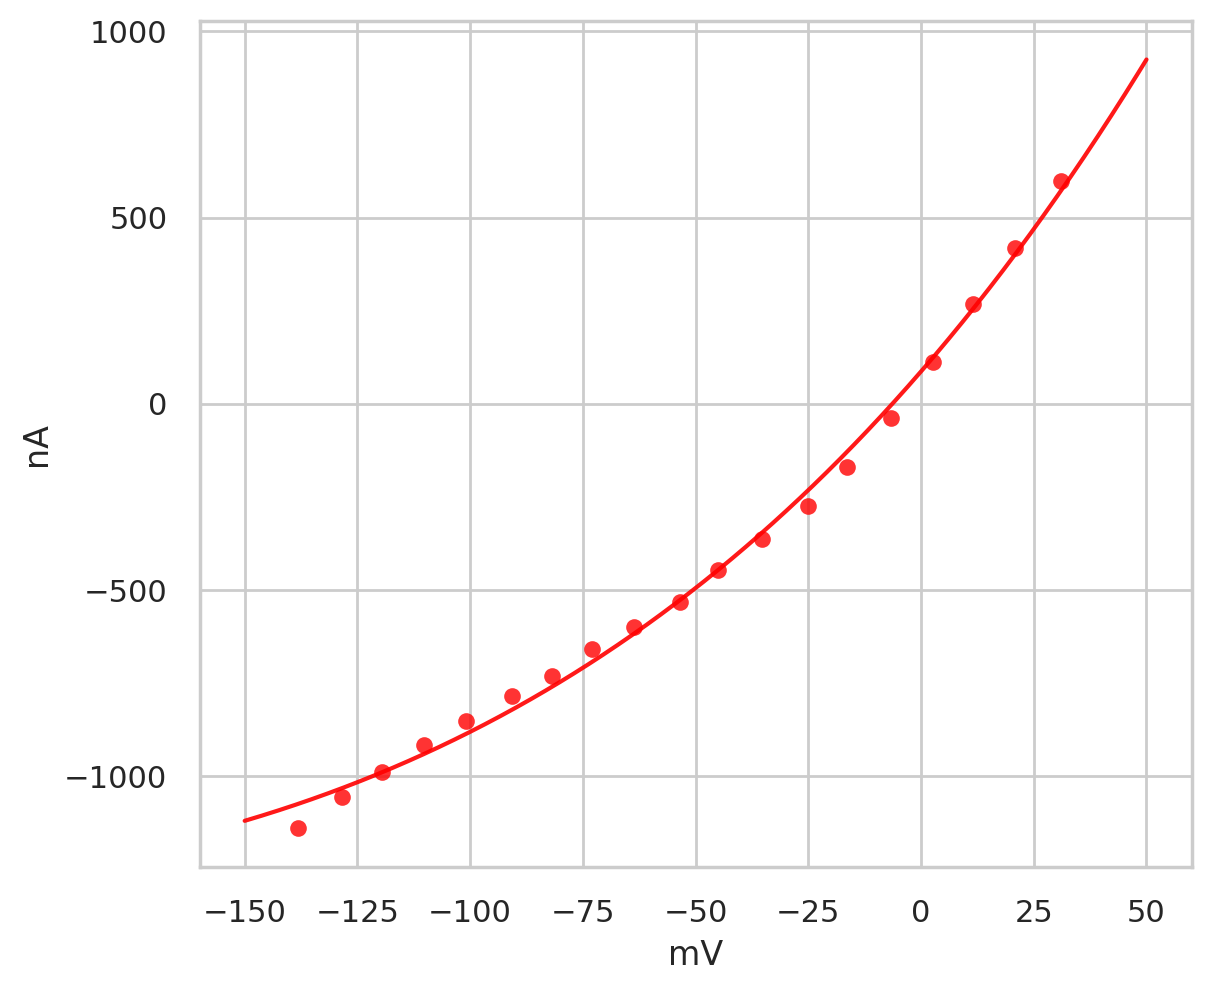

In [70]:
jtplot.style(theme='grade3')
Lu_4E_plot = plt.figure() 
mpl.rcParams['figure.dpi'] = 200 #Set the resolution 
sns.set(style="whitegrid")
# Storing fit parameters
Lu_4E_Fit_parameters = plsq2[0]
print(plsq2[0])
#Scatter plots of the data points
sns.regplot(x=v, y=i, fit_reg=False, color = 'red', label ='Control')
#plt.legend(['test'],loc="upper left")

#Fits a line to all points of the data-set and extapolates the rest.
#The goal here is to show how much deviation (or not) from linearity happens once the NMDA spike is evoked (or not evoked)
plt.plot(v_surr, peval2(v_surr,plsq2[0]),color='red',alpha=0.9)

# What is the Kolmogorov complexity score of the virus? (Sars-cov-2)
i.e. how many bytes of information does it contain?
These numbers are supposed to be the upper boundary (in bytes0

In [17]:
import zlib
# upper bound of Kolmogorov complexity for the virus (in bytes)
print("Playing with complexity score (Sars-cov-2)")
print("Kolmorov complexity (in bytes) :",len(zlib.compress(cc.encode("utf-8"))))

# Trying a different compression algorithm
import lzma
print("lzma compression algo:",len(lzma.compress(cc.encode("utf-8"))))

# can we compress a little further?
lcz = lzma.LZMACompressor()
data = lcz.compress(cc.encode("utf-8"))
data += lcz.flush()
print("trying to compress a little further with LZMA: ",len(data))

Playing with complexity score (Sars-cov-2)
Kolmorov complexity (in bytes) : 8859
lzma compression algo: 8408
trying to compress a little further with LZMA:  8408


# Edit distance

In [24]:
# Calculating the 'edit distance between Sarsv1 and Sars-cov-2' 
# Levenshtein distance
# https://pypi.org/project/editdistance/0.3.1/
import editdistance
print("Levenshtein distance between Sars_v1 and Sars-Cov-2: ",editdistance.eval(cc,Sars_v1),"\n")

# ORF1ab
print("Levenshtein distance between ORF1ab(Sars_v1 and Sars-Cov-2): ",editdistance.eval(ORF1ab,Sars1_ORF1ab))
print("Levenshtein distance translated ORF1ab(Sars_v1 and Sars-Cov-2): ",editdistance.eval(ORF1ab_tr,Sars1_ORF1ab_tr),"\n")

# Spike
print("Levenshtein distance between surface spike RNA (Sars_v1 and Sars-Cov-2): ",editdistance.eval(Spike,Sars1_Spike))
print("Levenshtein distance between surface spike glycoprotein (Sars_v1 and Sars-Cov-2): ",editdistance.eval(Spike_tr,Sars1_Spike_tr),"\n")

# structural protein; nucleocapsid phosphoprotein
print("Levenshtein distance between nucleocapsid (Sars_v1 and Sars-Cov-2): ",editdistance.eval(StructuralP_NP,Sars1_Protein_N))
print("Levenshtein distance between nucleocapsid phosphoprotein (Sars_v1 and Sars-Cov-2): ",editdistance.eval(StructuralP_NP_tr,Sars1_Protein_N_tr),"\n")

# ORF3a
print("Levenshtein distance between ORF3a (Sars_v1 and Sars-Cov-2): ",editdistance.eval(ORF3a,Sars1_ProteinX1))
print("Levenshtein distance between ORF3a protein (Sars_v1 (x1?) and Sars-Cov-2): ",editdistance.eval(ORF3a_tr,Sars1_ProteinX1_tr),"\n")

# structural protein; E protein
print("Levenshtein distance between E protein RNA (Sars_v1 and Sars-Cov-2): ",editdistance.eval(EProt,Sars1_ProteinE))
print("Levenshtein distance between E protein (Sars_v1 (x1?) and Sars-Cov-2): ",editdistance.eval(EProt_tr,Sars1_ProteinE_tr),"\n")



Levenshtein distance between Sars_v1 and Sars-Cov-2:  6014 

Levenshtein distance between ORF1ab(Sars_v1 and Sars-Cov-2):  4190
Levenshtein distance translated ORF1ab(Sars_v1 and Sars-Cov-2):  1765 

Levenshtein distance between surface spike RNA (Sars_v1 and Sars-Cov-2):  976
Levenshtein distance between surface spike glycoprotein (Sars_v1 and Sars-Cov-2):  297 

Levenshtein distance between nucleocapsid (Sars_v1 and Sars-Cov-2):  145
Levenshtein distance between nucleocapsid phosphoprotein (Sars_v1 and Sars-Cov-2):  40 

Levenshtein distance between ORF3a (Sars_v1 and Sars-Cov-2):  199
Levenshtein distance between ORF3a protein (Sars_v1 (x1?) and Sars-Cov-2):  75 

Levenshtein distance between E protein RNA (Sars_v1 and Sars-Cov-2):  14
Levenshtein distance between E protein (Sars_v1 (x1?) and Sars-Cov-2):  4 

